In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import disk, opening, closing
import glob
import h5py
import pathlib

In [22]:
rpi = 'h2r4'

# Read input image and resize them
path_to_folder = '../live_bees/' + rpi + '/random_images_25/*.jpg'
folder_in = sorted(glob.glob(path_to_folder))
names = [pathlib.Path(x).stem for x in folder_in]

folder_out = 'resized_images/' + rpi + '/'
n = 0
for img_path in folder_in:
    cv2.imwrite(folder_out + str(names[n]) + '.jpg', cv2.resize(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2GRAY), (0,0), fx=0.5, fy=0.5));
    n += 1

resized_imgs_path = sorted(glob.glob(folder_out + '*.jpg'))
print(cv2.imread(resized_imgs_path[0]).shape)

(1296, 2304, 3)


In [23]:
resized_imgs_path = sorted(glob.glob(folder_out + '*.jpg'))

ILASTIK_PATH = '/Users/fabianprofeta/Desktop/ilastik-1.4.0.post1-OSX.app/Contents/ilastik-release/run_ilastik.sh'
MODEL='trained_model.ilp'
IMG = ''
OUTPUT_FORMAT = 'png'
OUTPUT_FOLDER = './h5_files/'+ rpi + '/{nickname}_mask.png'
for img_path in resized_imgs_path:
    IMG += img_path + ' '
# we call ilastik as headless operation on the pc
!$ILASTIK_PATH  --headless \
                --project=$MODEL \
                --export_source='simple segmentation' \
                --output_format=$OUTPUT_FORMAT \
                --output_filename_format=$OUTPUT_FOLDER \
                $IMG

INFO ilastik.app: Using tiktorch executable: ['/Users/fabianprofeta/Desktop/ilastik-1.4.0.post1-OSX.app/Contents/ilastik-release/bin/python', '-m', 'tiktorch.server']
INFO ilastik.app: config file location: <none>
INFO ilastik.app: Starting ilastik from "/Users/fabianprofeta/Desktop/ilastik-1.4.0.post1-OSX.app/Contents/ilastik-release/lib/python3.7".
Starting ilastik from "/Users/fabianprofeta/Desktop/ilastik-1.4.0.post1-OSX.app/Contents/ilastik-release/lib/python3.7".
WARNING 2024-05-29 18:40:06,757 opConservationTracking 43458 4423747072 Could not find any ILP solver
WARNING 2024-05-29 18:40:06,798 opStructuredTracking 43458 4423747072 Could not find any ILP solver
WARNING 2024-05-29 18:40:06,800 structuredTrackingWorkflow 43458 4423747072 Could not find any learning solver. Tracking will use flow-based solver (DPCT). Learning for tracking will be disabled!
INFO ilastik.shell.projectManager: Opening Project: trained_model.ilp
INFO ilastik.workflows.pixelClassification.pixelClassifica

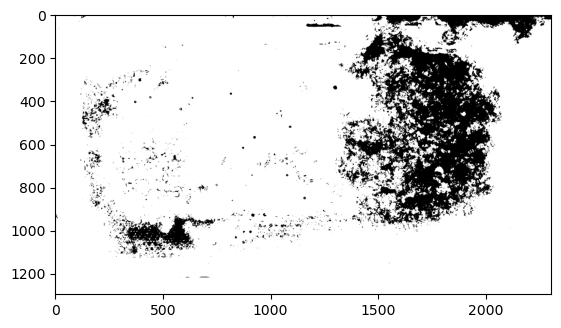

In [17]:
img = cv2.imread('h5_files/' + rpi + '/'+ names[8] + '_mask.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')